### Importing Python Packages 

In [19]:
import gmsh
import meshio
import dolfinx
import os
import pickle
import pyvista as pv
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from dolfinx.fem import (Constant, Function, FunctionSpace, 
                         assemble_scalar, dirichletbc, form, locate_dofs_geometrical,
                         locate_dofs_topological)
from dolfinx.fem.petsc import LinearProblem, NonlinearProblem
from dolfinx.mesh import create_rectangle, locate_entities
from dolfinx.plot import create_vtk_mesh
from dolfinx.nls.petsc import NewtonSolver
from dolfinx import log
from dolfinx import geometry
from mpi4py import MPI
from ufl import SpatialCoordinate, TestFunction, TrialFunction, Measure, dot, dx, ds, grad, inner
from petsc4py.PETSc import ScalarType
from functools import partial
from dolfinx.io import XDMFFile
from dolfinx.io import gmshio
from scipy.stats import binned_statistic

proc = MPI.COMM_WORLD.rank 

### Define auxiliary functions, constants, and parameters

In [20]:
# Densities (kg m-3).
rhoi = 917
rhow = 1026
rhos = 330

# Thermal Conductivity Values (W m-1 K-1).
k_ice = 2.1   # Sea ice conductivity
k_snow_3  = 0.3   # Snow conductivity (0.3 W m-1 K-1)
k_snow_1  = 0.1   # Snow conductivity (0.1 W m-1 K-1)

# Ocean Freezing Temperature in K (T_f = -1.8 K).
T_oce = 273.15 - 1.8

# Transect Parameters.
step = 1.1

# ITD discretization (m).
model_itd_bins = np.array([0.0, 0.6, 1.4, 2.4, 3.6, 100.0])

# Radiative parameters
sigma = 5.670374419 * 10**(-8)
emiss = 0.985
snow_albedo = 0.9 # Relevant only for spring transect

# 3d plotting
plot_3d = False

# The function below reads the data of the mosaic_tower dataset between two dates 
def met_data(datetime_1, datetime_2):
    met_data_folder = '/Users/zampieri/work/observations/mosaic_tower/'
    met_data_file = 'mosmet.metcity.level2v3.1min.{}*.nc'.format(datetime_1[0:7])
    met_data = xr.open_mfdataset('{}{}'.format(met_data_folder, met_data_file))
    met_data = met_data.sel(time = slice(datetime_1, datetime_2))
    met_data['temp_10m'] += 273.15
    met_data['temp_6m'] += 273.15
    met_data['temp_2m'] += 273.15
    met_data['skin_temp_surface'] += 273.15
    delta_T = (met_data['temp_10m'].mean() - met_data['skin_temp_surface'].mean()).values
    T_10m = met_data['temp_10m'].mean().values
    wspd_10m = np.sqrt(met_data['wspd_u_mean_10m']**2+met_data['wspd_v_mean_10m']**2).mean().values
    ldown = met_data['down_long_hemisp'].mean().values
    sdown = met_data['down_short_hemisp'].mean().values
    shcoef = 0.0012*1005*1.20*wspd_10m
    return(sdown, ldown, shcoef, delta_T)

### Dates corresponding to the available MOSAiC transects
20191226T120647 \
20200107T075304 \
20200115T122403 \
20200116T115614 \
20200119T112023 \
20200126T131018 \
20200320T122848 \
20200424T115507 \
20200424T124835 \
20200424T130256

### Helicopter Survey Time Bounds 
20191225T140809 20191225T154011 \
20200107T092304 20200107T105236 \
20200116T063418 20200116T075650 \
20200121T103600 20200121T122810 \
20200128T063509 20200128T080711 \
20200321T081331 20200321T100825 \
20200423T074432 20200423T093134 \
20200423T074432 20200423T093134 \
20200423T074432 20200423T093134

Chose one of the transects above and run the computations for that case. Note that, as described in the paper, the transect date does not correspond to the day the measurements were conducted on the ice, but to the closest in time helicopter survey (within 48h) on which the transect is colocated. 

In [21]:
file_array =         [['20191226T120647', '20200107T075304', '20200115T122403', '20200116T115614',
                       '20200119T112023', '20200126T131018', '20200320T122848', '20200424T115507',
                       '20200424T124835', '20200424T130256'],
                      ['20191225T140809', '20200107T092304', '20200116T063418', '20200116T063418',
                       '20200121T103600', '20200128T063509', '20200321T081331', '20200423T074432',
                       '20200423T074432', '20200423T074432'],
                      ['20191225T154011', '20200107T105236', '20200116T075650', '20200116T075650', 
                       '20200121T122810', '20200128T080711', '20200321T100825', '20200423T093134',
                       '20200423T093134', '20200423T093134']]

### Transect processing

In [22]:
# We choose the transect in position one of the previous list corresponding to '20200107T075304' by setting ind_transect.
ind_transect = 3
transect_string = file_array[0][ind_transect]
plot_date = '{}.{}.{}'.format(transect_string[0:4],transect_string[4:6],transect_string[6:8])
datetime_1 = file_array[1][ind_transect]
datetime_2 = file_array[2][ind_transect]
transect_file = '../data/transects/transect_{}.pkl'.format(transect_string)

if not os.path.isfile(transect_file):
    print('ERROR: Transect file does not exhist for {}!'.format(transect_string))
else:
    print('OK: File available for model computations. Reading the transect variables.')    
    with open(transect_file,'rb') as f:
        transect = pickle.load(f)

    fr_transect = transect[:,0]
    ts_transect = transect[:,1]
    hi_transect = transect[:,2]
    hs_transect = transect[:,3]
    # Cutoff for thin snow. We want to maintain a minimum snow thickness
    hs_transect[hs_transect < 0.02] = 0.02
    # Snow freeboard from thickness measurements – Constant density assumption
    sf_transect = ((rhow - rhoi)/rhow)*hi_transect + ((rhow - rhos)/rhow)*hs_transect
    ps_transect = np.arange(0, transect[:,:].shape[0])*step    
    vicen = binned_statistic(hi_transect, hi_transect, statistic='mean', bins=model_itd_bins).statistic
    vsnon = binned_statistic(hi_transect, hs_transect, statistic='mean', bins=model_itd_bins).statistic
    thericen = vicen + (vsnon*k_ice/k_snow_3)
    unit = hi_transect.copy()
    unit[:] = 1
    aicen = binned_statistic(hi_transect, unit, statistic='sum', bins=model_itd_bins).statistic

hi_transect_cesm = hi_transect.copy()
hs_transect_cesm = hi_transect.copy()
hi_transect_cesm_1d = hi_transect.copy()
hs_transect_cesm_1d = hi_transect.copy()
for i in range(0,len(hi_transect)):
    hi_transect_cesm_1d[i] = np.nanmean(vicen)
    hs_transect_cesm_1d[i] = np.nanmean(vsnon)    
    if i < np.sum(aicen[0:1]):
        hi_transect_cesm[i] = vicen[0]
        hs_transect_cesm[i] = vsnon[0]
    elif i < np.sum(aicen[0:2]):
        hi_transect_cesm[i] = vicen[1]
        hs_transect_cesm[i] = vsnon[1]
    elif i < np.sum(aicen[0:3]):
        hi_transect_cesm[i] = vicen[2]
        hs_transect_cesm[i] = vsnon[2]
    elif i < np.sum(aicen[0:4]):
        hi_transect_cesm[i] = vicen[3]
        hs_transect_cesm[i] = vsnon[3]
    elif i < np.sum(aicen[0:5]):
        hi_transect_cesm[i] = vicen[4]
        hs_transect_cesm[i] = vsnon[4]

OK: File available for model computations. Reading the transect variables.


### Build folder structure to save the transect diagnostics

In [23]:
transect_diagnostics = '../data/diagnostics/{}_figures/'.format(transect_string)
out = os.system('mkdir -p {}'.format(transect_diagnostics))

### Diagnostic plots to check the transect

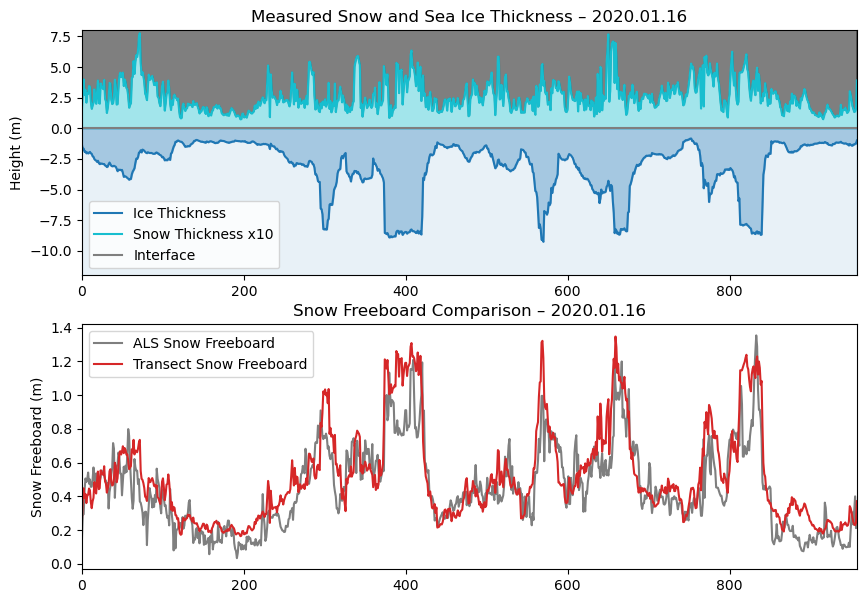

In [24]:
save_fig = False

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,7))

axs[0].plot(ps_transect, -hi_transect, color='tab:blue', label='Ice Thickness')
axs[0].fill_between(ps_transect, -hi_transect, color='tab:blue',alpha=0.4)
axs[0].fill_between(ps_transect, -hi_transect, -100-hi_transect, color='tab:blue',alpha=0.1)
axs[0].plot(ps_transect, hs_transect*10, color='tab:cyan', label='Snow Thickness x10')
axs[0].fill_between(ps_transect, hs_transect*10, color='tab:cyan',alpha=0.4)
axs[0].fill_between(ps_transect, hs_transect*10, 100+hs_transect*10, color='black',alpha=0.5)
axs[0].plot(ps_transect, np.zeros(ps_transect.shape), color='tab:gray', label='Interface')
axs[0].set_ylabel('Height (m)')
axs[0].set_title('Measured Snow and Sea Ice Thickness – '+plot_date)
axs[0].set_ylim((-12,8))
axs[0].set_xlim((ps_transect[0],ps_transect[-1]))
axs[0].legend()

axs[1].plot(ps_transect, fr_transect, color='tab:gray', label='ALS Snow Freeboard')
axs[1].plot(ps_transect, sf_transect, color='tab:red', label='Transect Snow Freeboard')
axs[1].set_ylabel('Snow Freeboard (m)')
axs[1].set_title('Snow Freeboard Comparison – '+plot_date)
axs[1].set_xlim((ps_transect[0],ps_transect[-1]))
axs[1].legend()

if save_fig:
    plt.savefig('{}EGU_transect_obs.png'.format(transect_diagnostics), bbox_inches='tight', dpi=200)
plt.show()

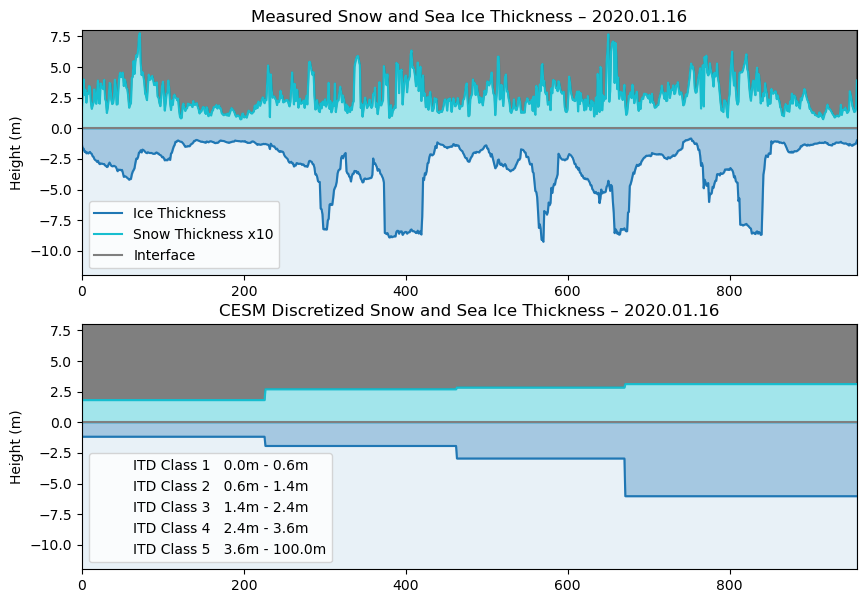

In [25]:
save_fig = True

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,7))

axs[0].plot(ps_transect, -hi_transect, color='tab:blue', label='Ice Thickness')
axs[0].fill_between(ps_transect, -hi_transect, color='tab:blue',alpha=0.4)
axs[0].fill_between(ps_transect, -hi_transect, -100-hi_transect, color='tab:blue',alpha=0.1)
axs[0].plot(ps_transect, hs_transect*10, color='tab:cyan', label='Snow Thickness x10')
axs[0].fill_between(ps_transect, hs_transect*10, color='tab:cyan',alpha=0.4)
axs[0].fill_between(ps_transect, hs_transect*10, 100+hs_transect*10, color='black',alpha=0.5)
axs[0].plot(ps_transect, np.zeros(ps_transect.shape), color='tab:gray', label='Interface')
axs[0].set_ylabel('Height (m)')
axs[0].set_title('Measured Snow and Sea Ice Thickness – '+plot_date)
axs[0].set_ylim((-12,8))
axs[0].set_xlim((ps_transect[0],ps_transect[-1]))
axs[0].legend()

axs[1].plot(ps_transect, -hi_transect_cesm, color='tab:blue')
axs[1].fill_between(ps_transect, -hi_transect_cesm, color='tab:blue',alpha=0.4)
axs[1].fill_between(ps_transect, -hi_transect_cesm, -100-hi_transect_cesm, color='tab:blue',alpha=0.1)
axs[1].plot(ps_transect, hs_transect_cesm*10, color='tab:cyan')
axs[1].fill_between(ps_transect, hs_transect_cesm*10, color='tab:cyan',alpha=0.4)
axs[1].fill_between(ps_transect, hs_transect_cesm*10, 100+hs_transect*10, color='black',alpha=0.5)
axs[1].plot(ps_transect, np.zeros(ps_transect.shape), color='tab:gray')
axs[1].set_ylabel('Height (m)')
axs[1].set_title('CESM Discretized Snow and Sea Ice Thickness – '+plot_date)
axs[1].set_ylim((-12,8))
axs[1].set_xlim((ps_transect[0],ps_transect[-1]))

for int_itd in range(0,5):
    axs[1].scatter(10, -100, s = 0.1, marker='o', color='white', alpha=0, 
                label='ITD Class '+str(int_itd+1)+'   '+ str(model_itd_bins[int_itd]) +'m - '+ str(model_itd_bins[int_itd+1]) +'m')
axs[1].legend(loc='lower left')

if save_fig:
    plt.savefig('{}EGU_transect_obs_2.png'.format(transect_diagnostics), bbox_inches='tight', dpi=200)
plt.show()

### Reat atmospheric forcing from met tower
Alternatively, constants can be used if you are just doing a test and don't have the dataset downloaded. 

In [26]:
T_surf = np.nanmean(ts_transect)
LW_down = 155
c_sens = 5.2
delta_T = 1
T_atm = T_surf + delta_T
ks_string = 'k3'

SW_down, LW_down, c_sens, delta_T = met_data(datetime_1, datetime_2)
print(SW_down, LW_down, c_sens, delta_T, T_atm)

0.0 156.74547707776324 12.427730868397452 1.2435514716488854 243.43753187584156


### Create Finite Element Mesh

In [ ]:
mesh_folder = '../data/meshes/{}/'.format(transect_string)
out = os.system('mkdir -p {}'.format(mesh_folder))

mesh_1d_folder = '../data/meshes/{}/mesh_1d/'.format(transect_string)
out = os.system('mkdir -p {}'.format(mesh_1d_folder))


gmsh.initialize()
snow_marker = 2
ice_marker = 1
ocean_ice_marker = 1
air_snow_marker = 2
if proc == 0:
    
    ### SNOW
    gmsh_pts = []
    for i in np.arange(hs_transect.size):
        gmsh_pts.append(gmsh.model.occ.addPoint(ps_transect[i], hs_transect[i], 0))
    # Add points for the base of the snow
    gmsh_pts.append(gmsh.model.occ.addPoint(ps_transect[-1], 0, 0))
    gmsh_pts.append(gmsh.model.occ.addPoint(ps_transect[0], 0, 0))
    # Now add lines connecting each sequential pair of points
    gmsh_lines = []
    for i in np.arange(len(gmsh_pts)-1):
        gmsh_lines.append(gmsh.model.occ.addLine(gmsh_pts[i], gmsh_pts[i+1]))
    # Add line connecting the final point to the first point
    gmsh_lines.append(gmsh.model.occ.addLine(gmsh_pts[-1], gmsh_pts[0]))
    # Connect all of the lines into a curve loop
    gmsh_curve_loop = gmsh.model.occ.addCurveLoop(gmsh_lines)
    # Finally, fill the space inside the curve loop with a planar surface
    gmsh_snow = gmsh.model.occ.addPlaneSurface([gmsh_curve_loop])
    gmsh_lines_snow = gmsh_lines.copy()
    
    
    ### ICE
    gmsh_pts = []
    for i in np.arange(hs_transect.size):
        gmsh_pts.append(gmsh.model.occ.addPoint(ps_transect[i], -hi_transect[i], 0))
    # Add points for the base of the snow
    gmsh_pts.append(gmsh.model.occ.addPoint(ps_transect[-1], 0, 0))
    gmsh_pts.append(gmsh.model.occ.addPoint(ps_transect[0], 0, 0))
    # Now add lines connecting each sequential pair of points
    gmsh_lines = []
    for i in np.arange(len(gmsh_pts)-1):
        gmsh_lines.append(gmsh.model.occ.addLine(gmsh_pts[i], gmsh_pts[i+1]))
    # Add line connecting the final point to the first point
    gmsh_lines.append(gmsh.model.occ.addLine(gmsh_pts[-1], gmsh_pts[0]))
    # Connect all of the lines into a curve loop
    gmsh_curve_loop = gmsh.model.occ.addCurveLoop(gmsh_lines)
    # Finally, fill the space inside the curve loop with a planar surface
    gmsh_ice = gmsh.model.occ.addPlaneSurface([gmsh_curve_loop])
    gmsh_lines_ice = gmsh_lines.copy()
    
    # Fragment connects the top of the ice with the base of the snow
    gmsh.model.occ.fragment([(2, 1)], [(2, 2)])
    
    # Synchronize tells gmsh to actually add the items
    gmsh.model.occ.synchronize()
    
    # Let's target a reasonable mesh size
    gmsh.model.mesh.setSize(gmsh.model.getEntities(0), 0.15)
    
    # Add physical groups to mark the surfaces
    gmsh.model.addPhysicalGroup(2, [gmsh_ice], ice_marker)
    gmsh.model.addPhysicalGroup(2, [gmsh_snow], snow_marker)
    
    gmsh.model.addPhysicalGroup(1, gmsh_lines_ice[:-3], ocean_ice_marker)
    gmsh.model.addPhysicalGroup(1, gmsh_lines_snow[:-3], air_snow_marker)

    gmsh.model.mesh.generate(2)
    
    gmsh.write('{}mesh.msh'.format(mesh_folder))
    
gmsh.finalize()

def create_mesh(mesh, cell_type, prune_z=False):
    cells = mesh.get_cells_type(cell_type)
    cell_data = mesh.get_cell_data('gmsh:physical', cell_type)
    points = mesh.points[:,:2] if prune_z else mesh.points
    out_mesh = meshio.Mesh(points=points, cells={cell_type: cells}, cell_data={'name_to_read':[cell_data]})
    return out_mesh

mesh, cell_markers, facet_markers = gmshio.read_from_msh('{}mesh.msh'.format(mesh_folder), MPI.COMM_WORLD, gdim=2)

if proc == 0:
    # Read in mesh
    msh = meshio.read('{}mesh.msh'.format(mesh_folder))
   
    # Create and save one file for the mesh, and one file for the facets 
    triangle_mesh = create_mesh(msh, 'triangle', prune_z=True)
    line_mesh = create_mesh(msh, 'line', prune_z=True)
    meshio.write('{}mesh.xdmf'.format(mesh_folder), triangle_mesh)
    meshio.write('{}mt.xdmf'.format(mesh_folder), line_mesh)
    
with XDMFFile(MPI.COMM_WORLD, '{}mesh.xdmf'.format(mesh_folder), 'r') as xdmf:
    mesh = xdmf.read_mesh(name="Grid")
    ct = xdmf.read_meshtags(mesh, name='Grid')
mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim-1)
with XDMFFile(MPI.COMM_WORLD, '{}mt.xdmf'.format(mesh_folder), 'r') as xdmf:
    ft = xdmf.read_meshtags(mesh, name='Grid')
    
bb_tree = geometry.BoundingBoxTree(mesh, mesh.topology.dim)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 10%] Meshing curve 7 (Line)
Info    : [ 10%] Meshing curve 8 (Line)
Info    : [ 10%] Meshing curve 9 (Line)
Info    : [ 10%] Meshing curve 10 (Line)
Info    : [ 10%] Meshing curve 11 (Line)
Info    : [ 10%] Meshing curve 12 (Line)
Info    : [ 10%] Meshing curve 13 (Line)
Info    : [ 10%] Meshing curve 14 (Line)
Info    : [ 10%] Meshing curve 15 (Line)
Info    : [ 10%] Meshing curve 16 (Line)
Info    : [ 10%] Meshing curve 17 (Line)
Info    : [ 10%] Meshing curve 18 (Line)
Info    : [ 10%] Meshing curve 19 (Line)
Info    : [ 10%] Meshing curve 20 (Line)
Info    : [ 10%] Meshing curve 21 (Line)
Info    : [ 10%] Meshing curve 22 (Line)
Info    : [ 10%] Meshing curve 23 (Line)
Info    : [ 10%] Meshing curve 24 (Line)
I

2023-10-02 12:49:22.608 (1284.597s) [main            ]              utils.cpp:616   INFO| Compute partition of cells across ranks
2023-10-02 12:49:22.608 (1284.597s) [main            ]         graphbuild.cpp:533   INFO| Building mesh dual graph
2023-10-02 12:49:22.608 (1284.597s) [main            ]         graphbuild.cpp:396   INFO| Build local part of mesh dual graph
2023-10-02 12:49:22.821 (1284.811s) [main            ]         graphbuild.cpp:89    INFO| Build nonlocal part of mesh dual graph
2023-10-02 12:49:22.822 (1284.811s) [main            ]         graphbuild.cpp:545   INFO| Graph edges (local: 1125324, non-local: 0)
2023-10-02 12:49:22.822 (1284.811s) [main            ]       partitioners.cpp:523   INFO| Compute graph partition using ParMETIS
2023-10-02 12:49:22.824 (1284.814s) [main            ]                MPI.cpp:165   INFO| Computing communication graph edges (using NBX algorithm). Number of input edges: 1
2023-10-02 12:49:22.824 (1284.814s) [main            ]          

### Plot Mesh

In [11]:
topology, cell_types, x = create_vtk_mesh(mesh, mesh.topology.dim) 
grid = pv.UnstructuredGrid(topology, cell_types, x) 
num_local_cells = mesh.topology.index_map(mesh.topology.dim).size_local 
grid.cell_data['Marker'] = ct.values[ct.indices<num_local_cells] 
grid.set_active_scalars('Marker')

if plot_3d:
    pl = pv.Plotter(window_size=[800, 800], shape=(1,1)) 
    pl.subplot(0,0) 
    pl.add_mesh(grid, show_edges=False) 
    pl.show()

## Solve and plot the solution to the 2d heat equation

In [12]:
Q = FunctionSpace(mesh, ("DG", 0))
kappa = Function(Q)
bottom_cells = ct.find(ice_marker)
kappa.x.array[bottom_cells] = np.full_like(bottom_cells, k_ice, dtype=ScalarType)
top_cells = ct.find(snow_marker)
kappa.x.array[top_cells]  = np.full_like(top_cells, k_snow_3, dtype=ScalarType)

In [13]:
V = FunctionSpace(mesh, ("CG", 2))
u_bc = Function(V)

# Facets
lower_facets = ft.find(ocean_ice_marker)
upper_facets = ft.find(air_snow_marker)
facets = np.hstack([lower_facets, upper_facets])
# Dofs
lower_dofs = locate_dofs_topological(V, mesh.topology.dim-1, lower_facets)
upper_dofs = locate_dofs_topological(V, mesh.topology.dim-1, upper_facets)
# Values
lower_values = np.full_like(lower_facets, 1)
upper_values = np.full_like(upper_facets, 2)
values = np.hstack([lower_values, upper_values])
# Sort order
sort_order = np.argsort(facets)

# Dirchlet Lower boundary condition
bcs = [dirichletbc(value=ScalarType(T_oce), dofs=lower_dofs, V=V)]

# Robin upper boundary conditions – define measure ds
facet_tags = dolfinx.mesh.meshtags(mesh, mesh.topology.dim - 1, facets[sort_order], values[sort_order])
ds = Measure('ds', domain=mesh, subdomain_data=facet_tags)

In [14]:
# Set up variational problem and solve

u, v = TrialFunction(V), TestFunction(V)
a = inner(kappa*grad(u), grad(v)) * dx + c_sens*u*v*ds(2)
x = SpatialCoordinate(mesh)
L = Constant(mesh, ScalarType(0)) * v * dx + c_sens*T_atm*v*ds(2)

problem = LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

In [15]:
if plot_3d:
    p = pv.Plotter(window_size=[800, 800], shape=(1,1)) 
    p.subplot(0,0) 
    grid_uh = pv.UnstructuredGrid(*create_vtk_mesh(V)) 
    grid_uh.point_data["u"] = uh.x.array.real 
    grid_uh.set_active_scalars("u") 
    actor1 = p.add_mesh(grid_uh, show_edges=False) 
    p.show()

In [16]:
v = TestFunction(V)
u = uh
F = (inner(kappa*grad(u), grad(v)) * dx 
     - (1-snow_albedo)*SW_down*v*ds(2) - LW_down*v*ds(2) + sigma*emiss*u**4*v*ds(2)    # Longwave up and down    
     - c_sens*T_atm*v*ds(2) + c_sens*u*v*ds(2)            # Sensible
     - Constant(mesh, ScalarType(0))*v*dx )

problem = NonlinearProblem(F, u, bcs=bcs)

solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
#solver.nonzero_initial_guess=True
solver.rtol = 1e-6
solver.report = True

log.set_log_level(log.LogLevel.INFO)
n, converged = solver.solve(uh)
assert(converged)
print(f"Number of interations: {n:d}")

2023-10-02 12:29:47.708 ( 109.529s) [main            ]              petsc.cpp:675   INFO| PETSc Krylov solver starting to solve system.


Number of interations: 3


2023-10-02 12:29:56.996 ( 118.817s) [main            ]              petsc.cpp:675   INFO| PETSc Krylov solver starting to solve system.
2023-10-02 12:29:59.153 ( 120.974s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 3.26223 (tol = 1e-10) r (rel) = 0.00326193(tol = 1e-06)
2023-10-02 12:29:59.398 ( 121.218s) [main            ]              petsc.cpp:675   INFO| PETSc Krylov solver starting to solve system.
2023-10-02 12:30:01.906 ( 123.727s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 3.42275e-05 (tol = 1e-10) r (rel) = 3.42243e-08(tol = 1e-06)
2023-10-02 12:30:01.906 ( 123.727s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 3 iterations and 3 linear solver iterations.


In [17]:
if plot_3d:
    p = pv.Plotter(window_size=[800, 800], shape=(1,1)) 
    p.subplot(0,0) 
    grid_uh = pv.UnstructuredGrid(*create_vtk_mesh(V)) 
    grid_uh.point_data["u"] = uh.x.array.real 
    grid_uh.set_active_scalars("u") 
    actor1 = p.add_mesh(grid_uh, show_edges=False) 
    p.show()

### Extract output and save it to file

In [18]:
data_folder = '../data/diagnostics/{}_data/'.format(transect_string)
out = os.system('mkdir -p {}'.format(data_folder))

# Now extract the temperatures a short distance above the base of the ice and caluclate heat flux
tol = 0.001 # Avoid hitting the outside of the domain
x_plt = ps_transect
x_plt[0] += tol
x_plt[-1] -= tol
points = np.zeros((3, x_plt.size))
points[0] = x_plt
points[1] = 0
u_values = []

cells = []
points_on_proc = []
# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions(bb_tree, points.T)
# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(mesh, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i))>0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])

points_on_proc = np.array(points_on_proc, dtype=np.float64)
T_interface = uh.eval(points_on_proc, cells)

tol = 0.001 # Avoid hitting the outside of the domain
x_plt = ps_transect
x_plt[0] += tol
x_plt[-1] -= tol
points = np.zeros((3, x_plt.size))
points[0] = x_plt
points[1] = hs_transect[:] - tol
u_values = []

cells = []
points_on_proc = []
# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions(bb_tree, points.T)
# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(mesh, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i))>0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])

points_on_proc = np.array(points_on_proc, dtype=np.float64)
T_top = uh.eval(points_on_proc, cells)

tol = 0.001 # Avoid hitting the outside of the domain
x_plt = ps_transect
x_plt[0] += tol
x_plt[-1] -= tol
points = np.zeros((3, x_plt.size))
points[0] = x_plt
points[1] = -hi_transect[:] + tol
u_values = []

cells = []
points_on_proc = []
# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions(bb_tree, points.T)
# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(mesh, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i))>0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])

points_on_proc = np.array(points_on_proc, dtype=np.float64)
T_bottom = uh.eval(points_on_proc, cells)

tol = 0.001 # Avoid hitting the outside of the domain
x_plt = ps_transect
x_plt[0] += tol
x_plt[-1] -= tol
points = np.zeros((3, x_plt.size))
points[0] = x_plt
points[1] = hs_transect[:]*0.5
u_values = []

cells = []
points_on_proc = []
# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions(bb_tree, points.T)
# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(mesh, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i))>0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])

points_on_proc = np.array(points_on_proc, dtype=np.float64)
T_half_snow = uh.eval(points_on_proc, cells)

tol = 0.001 # Avoid hitting the outside of the domain
x_plt = ps_transect
x_plt[0] += tol
x_plt[-1] -= tol
points = np.zeros((3, x_plt.size))
points[0] = x_plt
points[1] = -hi_transect[:]*0.5
u_values = []

cells = []
points_on_proc = []
# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions(bb_tree, points.T)
# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(mesh, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i))>0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])

points_on_proc = np.array(points_on_proc, dtype=np.float64)
T_half_ice = uh.eval(points_on_proc, cells)

tol = 0.001 # Avoid hitting the outside of the domain
x_plt = ps_transect
x_plt[0] += tol
x_plt[-1] -= tol
points = np.zeros((3, x_plt.size))
points[0] = x_plt
points[1] = -hi_transect[:] + 0.1
u_values = []

cells = []
points_on_proc = []
# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions(bb_tree, points.T)
# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(mesh, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i))>0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])

points_on_proc = np.array(points_on_proc, dtype=np.float64)
T_semibot_ice = uh.eval(points_on_proc, cells)

T_half_ice[T_half_ice==0] = np.nan
T_half_snow[T_half_snow==0] = np.nan
T_top[T_top==0] = np.nan
T_bottom[T_bottom==0] = np.nan
T_semibot_ice[T_semibot_ice==0] = np.nan
T_interface[T_interface==0] = np.nan

with open('{}solution_2d_{}_test.pkl'.format(data_folder, ks_string),'wb') as f:
    pickle.dump([T_half_ice[:,0], T_half_snow[:,0], T_top[:,0], T_bottom[:,0], T_interface[:,0], T_semibot_ice[:,0]], f)